In [1]:
#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from tensorflow import keras
%matplotlib inline
import pylab as pl
from IPython import display


import sys
sys.path.append("..") # Adds higher directory to python modules path.

import branchingdnn as branching
from branchingdnn import core
from branchingdnn.utils import * 
from branchingdnn.profiler import model_profiler as profiler
from branchingdnn.dataset import prepare
from branchingdnn.branches import branch

# from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [2]:
# Download MNIST dataset
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# print(y_train)
K= 10 # number of classes

In [3]:
train_images = train_images.reshape(60000, 784).astype("float32") / 255
test_images = test_images.reshape(10000, 784).astype("float32") / 255


train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels,10)

print(len(train_labels))
print(len(test_labels))
print(train_labels[0])
print((test_labels[0]))
# plt.imshow(train_images[1].reshape(228,228)) 
# plt.show()

60000
10000
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [4]:
validation_size = 12000
shuffle_size = 20000
batch_size=128
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))


def augment_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    # image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    # image = tf.image.resize(image, (28,28))
    return image, label
train_ds_size = len(list(train_ds))
test_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))
train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))

target = tf.data.Dataset.from_tensor_slices((train_labels))
train_ds = tf.data.Dataset.zip((train_ds,target))

v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))

t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))


print("trainSize {}".format(train_ds_size))
print("testSize {}".format(test_ds_size))
train_ds = (train_ds
                
                .shuffle(buffer_size=tf.cast(shuffle_size,'int64'))
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
               
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
               
                #   .shuffle(buffer_size=validation_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))



trainSize 48000
testSize 10000


In [5]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)
    
def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl
def mse_loss(labels, alpha): 
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S

        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

#         annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
        annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
#         C =  annealing_coef * KL(alp)
#         print(alpha)
        C = keras_kl(labels, alpha)
        return (A + B) + C
    
    
def loss_function(annealing_rate=1, momentum=1, decay=1):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    
    
    def mse_loss(labels, alpha): 
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S

        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

#         annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
        annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
#         C =  annealing_coef * KL(alp)
#         print(alpha)
        C = keras_kl(labels, alpha)
        return (A + B) + C
    
    def mse_loss_global(labels, outputs): 
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S

        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
#         print(alpha)
#         C = keras_kl(labels, alpha)
        return (A + B) + C
    return  mse_loss_global





In [6]:
class EvidenceEndpoint(keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(EvidenceEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = loss_function()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = relu_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
#             print(outputs)
            softmax = tf.nn.softmax(outputs)
#             print(softmax)
#             print(labels)
            evidence = softplus_evidence(outputs)
            alpha = evidence + 1

            loss = tf.reduce_mean(self.loss_fn(labels, outputs))
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
            prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            l2_loss = tf.nn.l2_loss(self.weights) * self.lmb
            total_loss = loss + l2_loss
            self.add_loss(total_loss)
            pred = tf.argmax(outputs,1)
# #             print("pred", pred)
#             results = tf.one_hot(pred,self.num_outputs)
            truth = tf.argmax(labels,1)
# #             print("truth", truth)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
# #             print("match", match)
            total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_avg = tf.reduce_mean(total_evidence)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )

            
            self.add_metric(evidence, name=self.name+"_evidence")
            self.add_metric(u, name=self.name+"_uncertainty")
            self.add_metric(mean_avg, name=self.name+"_mean_ev_avg")
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ")
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail")
            
            
#             total_loss =tf.reduce_mean(normal_loss) + l2_loss
            # print(total_loss)
#             total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
            # print(total_evidence)
#             pred = tf.argmax(outputs, 1)
#             truth = tf.argmax(labels, 1)
#             match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
#             # print("match",match)
#             
#             # print("mean_Avg")


            # print('metrics')
#             self.add_loss(total_loss)
            # print("pred",inputs)
            # print("loss")
     
            
            return softmax
    

In [7]:
class AnnealingCallback(keras.callbacks.Callback):
    def __init__(self, annealing_point, verbose=1, **kwargs):
        #annealing_point is the point when the annealing temperature is at max. this is given as a value in terms of batches.
        #at the start of X batches, the temperature will be at max
        #temperature is checked at the start of each batch
        
        self.annealing_point = annealing_point
        self.step_counter = 0
        self.verbose = verbose
        return None
    def on_train_begin(self, logs=None):
        #initialize the annealing at training start 
        
        ### if the annealing_point is 0, then start the full temperature immediately (1).
        if annealing_point == 0:
            self.annealing_rate = 1            
        else:
            self.annealing_rate = 0
        
        self.model.loss = loss_function(self.annealing_point) 
        if self.verbose==2:
            print("Starting training; Loss: {}".format(self.model.loss))
        
    def on_train_batch_begin(self, batch, logs=None):
        self.step_counter = self.step_counter + 1
        self.annealing_rate = tf.minimum(1.0, tf.cast(self.step_counter/self.annealing_point,tf.float32))
        self.model.loss = loss_function(self.annealing_point)
        if self.verbose==2:
            print("...Training: step: {} start of batch {}; annealing_rate = {}".format(self.step_counter, batch, self.annealing_rate))

In [8]:
outputs =[]
inputs = keras.Input(shape=(784,))
targets = keras.Input(shape=(10,),name='targets')
x = layers.Flatten(input_shape=(28,28))(inputs)
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 2
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 3
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 4
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 5
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 1 The main branch exit is refered to as "exit 1" or "main exit" to avoid confusion when adding addtional exits
# output1 = layers.Dense(10, name="output1")(x)
# softmax = layers.Softmax()(output1)
output = EvidenceEndpoint(10, activation='relu')(x,targets)


outputs.append(output)
print(len(outputs))
model = keras.Model(inputs=[inputs,targets], outputs=output, name="mnist_model_normal")
model.summary()
#visualize_model(model,"mnist_normal")
print(len(model.outputs))


1
Model: "mnist_model_normal"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      flatten[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           dense[0][0]                      
_______________________________________________________________________________

In [181]:
outputs =[]
inputs = keras.Input(shape=(784,))
targets = keras.Input(shape=(10,),name='targets')
# 5,5,1,20
#conv2d(5,5,1,20)
#maxpool
#flatten
#dense(500, relu)
#dropout(.5)
#dense(10)
x = layers.Reshape((28,28,1))(inputs)
x = layers.Conv2D( 20,kernel_size=(1,1),activation='relu')(x)
x = layers.MaxPooling2D( strides=(2,2),padding="same")(x)

x = layers.Conv2D( 50,kernel_size=(1,1),activation='relu')(x)
x = layers.MaxPooling2D( strides=(2,2),padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(500,activation="relu")(x)
x = layers.Dropout(.5)(x)
# output = layers.Dense(10,activation="relu")(x)


#exit 1 The main branch exit is refered to as "exit 1" or "main exit" to avoid confusion when adding addtional exits
# output1 = layers.Dense(10, name="output1")(x)
# softmax = layers.Softmax()(output1)
output = EvidenceEndpoint(10, activation='relu')(x,targets)

outputs.append(output)
print(len(outputs))
model = keras.Model(inputs=[inputs,targets], outputs=output, name="mnist_model_normal")
model.summary()
#visualize_model(model,"mnist_normal")
print(len(model.outputs))


1
Model: "mnist_model_normal"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
reshape_43 (Reshape)            (None, 28, 28, 1)    0           input_68[0][0]                   
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 28, 28, 20)   40          reshape_43[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_50 (MaxPooling2D) (None, 14, 14, 20)   0           conv2d_73[0][0]                  
_______________________________________________________________________________

In [182]:
# # define some utility functions
# def var(name, shape, init=None):
#     if init is None:
#         init = tf.compat.v1.truncated_normal_initializer(stddev=(2/shape[0])**0.5)
#     return tf.compat.v1.get_variable(name=name, shape=shape, dtype=tf.float32,
#                           initializer=init)

# def conv(Xin, f, strides=[1, 1, 1, 1], padding='SAME'):
#     return tf.nn.conv2d(Xin, f, strides, padding)

# def max_pool(Xin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
#     return tf.nn.max_pool(Xin, ksize, strides, padding)

# def rotate_img(x, deg):
#     import scipy.ndimage as nd
#     return nd.rotate(x.reshape(28,28),deg,reshape=False).ravel()
#  # second hidden layer - conv
# W2 = var('W2', [5,5,20,50])
# b2 = var('b2', [50])
# conv = conv(out1, W2, strides=[1, 1, 1, 1])

# out2 = max_pool(tf.nn.relu(conv + b2))
# print("target", out2)
# x = layers.Reshape((28,28,1))(inputs)
# x = layers.Conv2D( 20,kernel_size=(1,1),activation='relu')(x)
# x = layers.MaxPooling2D( strides=(2,2),padding="same")(x)

# x = layers.Conv2D( 50,kernel_size=(1,1),activation='relu')(x)
# x = layers.MaxPooling2D( strides=(2,2),padding="same")(x)
# x = layers.Flatten()(x)
# x = layers.Dense(500,activation="relu")(x)
# x = layers.Dropout(.5)(x)
# output = layers.Dense(10,activation="relu")(x)

# print(x)
# # print(conv)
# # out1 = max_pool(tf.nn.relu(conv+ b1))
# # print(out1)

In [228]:
epochs = 50 
annealing_point = 1
annealing_rate = 0.1
# decay = learning_rate /epochs
momentum = 0.8
loss_fn = loss_function(1)
model.compile( loss=loss_fn, optimizer=tf.optimizers.Adam(), metrics=['accuracy'],run_eagerly=True)
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=5)
#           callbacks=[AnnealingCallback(48*10)])



Epoch 1/50
375/375 [==============================] - 13s 35ms/step - loss: 2.6627 - accuracy: 0.2759 - evidence_endpoint_21_evidence: 1.1814 - evidence_endpoint_21_uncertainty: 0.7971 - evidence_endpoint_21_mean_ev_avg: 11.8136 - evidence_endpoint_21_mean_ev_succ: 21.3059 - evidence_endpoint_21_mean_ev_fail: 0.2861
Epoch 2/50
375/375 [==============================] - 14s 36ms/step - loss: 2.2310 - accuracy: 0.7268 - evidence_endpoint_21_evidence: 3.3624 - evidence_endpoint_21_uncertainty: 0.5443 - evidence_endpoint_21_mean_ev_avg: 33.6241 - evidence_endpoint_21_mean_ev_succ: 42.5100 - evidence_endpoint_21_mean_ev_fail: 0.9614
Epoch 3/50
375/375 [==============================] - 13s 36ms/step - loss: 1.9850 - accuracy: 0.9070 - evidence_endpoint_21_evidence: 5.4556 - evidence_endpoint_21_uncertainty: 0.3462 - evidence_endpoint_21_mean_ev_avg: 54.5558 - evidence_endpoint_21_mean_ev_succ: 59.2010 - evidence_endpoint_21_mean_ev_fail: 2.9075
Epoch 4/50
375/375 [==========================

KeyboardInterrupt: 

In [22]:
model.evaluate(test_ds)

10000/10000 [==============================] - 153s 15ms/step - loss: 0.0409 - accuracy: 0.9779 - evidence_endpoint_2_evidence: 260.4743 - evidence_endpoint_2_mean_ev_avg: 2604.7429 - evidence_endpoint_2_mean_ev_succ: 2590.1184 - evidence_endpoint_2_mean_ev_fail: 14.6261s - loss: 0.0393 - accuracy: 0.9787 - evidence_endpoint_2_evidence: 261.1822 


[0.04087047278881073,
 0.9779000282287598,
 260.47430419921875,
 2604.742919921875,
 2590.118408203125,
 14.626081466674805]

In [442]:
# model.save("mnist_notebook.hdf5")

In [229]:
def displayEvidence(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pAcc=[]
    for i in range(len(test_ds)-1):
#     for i in range(1000):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.test_on_batch(item[0],item[1])
#         print("accuracy:", x[1], "evidence:",x[2])
        pClass.append(tf.argmax(item[1],1).numpy()[0])
        pEvidence.append(x[2])
        pAcc.append(x[1])       
        pUncertainty.append(x[3])   
#     print(pClass)
#     print(pEvidence)
#     print(pAcc)
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"uncertainty":pUncertainty})
    
#     print(Predictions)
    E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
    E_threshold = E_threshold.iloc[0]
    print("evidence Threshold >= correct: ", E_threshold)
    U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
    U_threshold = U_threshold.iloc[0]
    print("uncertainty Threshold <= correct: ", U_threshold)

    print("Uncertainty")
    print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >U_threshold)].sort_values("uncertainty").shape)
    print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

    print("Evidence")
    print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape)
    print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)
  
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]

    fig.suptitle('Horizontally stacked subplots')
    axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    axs[0].plot(np.repeat(E_threshold,11),'b--')
    axs[0].set_title("evidence")

    axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
    axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
    axs[1].plot(np.repeat(U_threshold,11),'b--')

    axs[1].set_title("uncertainty")

    fig.set_size_inches(10, 10)
    plt.show()
    return Predictions


In [230]:
###keras KL activated model 47 epochs
Predictions = displayEvidence(model,test_ds)

10000
evidence Threshold >= correct:  2.2423536753088507
uncertainty Threshold <= correct:  0.6180661885707943
Uncertainty
Passed correct answers: (718, 4)
Accepted incorrect answers (70, 4)
Evidence
Passed correct answers: (1326, 4)
Accepted incorrect answers (36, 4)


          label  evidence  uncertainty
Acc                                   
0.000000    442       442          442
0.952747      1         1            1
1.000000   9556      9556         9556
             label   evidence  uncertainty
Acc                                       
0.000000  5.658371   0.549046     0.874076
0.952747  2.000000   9.801637     0.225834
1.000000  4.387191  10.418971     0.187785
             label  evidence  uncertainty
Acc                                      
0.000000  2.951388  1.693308     0.256010
0.952747       NaN       NaN          NaN
1.000000  2.881134  7.612239     0.234972
evidence Threshold >= correct:  2.2423536753088507
uncertainty Threshold <= correct:  0.6180661885707943
Uncertainty
Passed correct answers: (718, 4)
Accepted incorrect answers (70, 4)
Evidence
Passed correct answers: (1326, 4)
Accepted incorrect answers (36, 4)


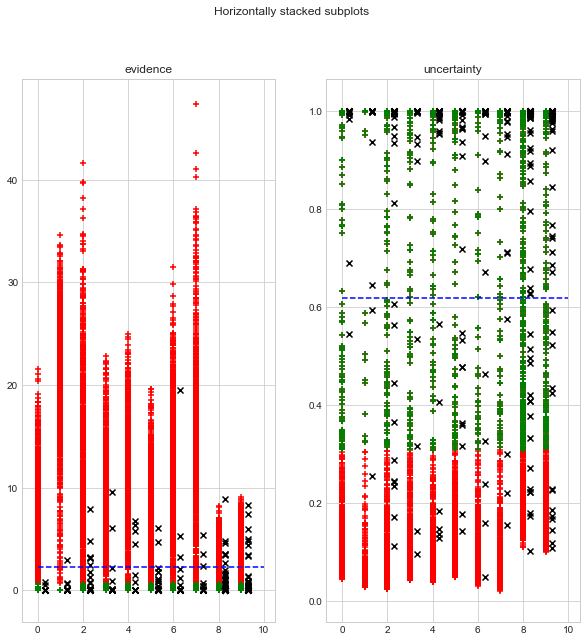

In [236]:
print(Predictions.groupby("Acc").count())
print(Predictions.groupby("Acc").mean())
print(Predictions.groupby("Acc").std())
E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
E_threshold = E_threshold.iloc[0]
print("evidence Threshold >= correct: ", E_threshold)
U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
U_threshold = U_threshold.iloc[0]
print("uncertainty Threshold <= correct: ", U_threshold)

print("Uncertainty")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >=U_threshold)].sort_values("uncertainty").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

print("Evidence")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] <= E_threshold)].sort_values("evidence").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)

fig, axs = plt.subplots(1, 2)
    
correct_rows = Predictions.loc[Predictions['Acc'] == True]
incorrect_rows = Predictions.loc[Predictions['Acc'] == False]


E_correct_rows_missed = Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] <= E_threshold)].sort_values("evidence")
E_incorrect_rows_accepted = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence")


U_correct_rows_missed = Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >=U_threshold)].sort_values("uncertainty")
U_incorrect_rows_accepted = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty")

fig.suptitle('Horizontally stacked subplots')
axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
axs[0].scatter(U_correct_rows_missed['label'],U_correct_rows_missed['evidence'],c ='g',marker='+')
axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
axs[0].plot(np.repeat(E_threshold,11),'b--')
axs[0].set_title("evidence")

axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
axs[1].scatter(E_correct_rows_missed['label'],E_correct_rows_missed['uncertainty'],c ='g',marker='+')
axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
axs[1].plot(np.repeat(U_threshold,11),'b--')

axs[1].set_title("uncertainty")

fig.set_size_inches(10, 10)
plt.show()

In [226]:
print(Predictions.groupby("Acc").count())
print(Predictions.groupby("Acc").mean())
print(Predictions.groupby("Acc").std())
E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
E_threshold = E_threshold.iloc[0]
print("evidence Threshold >= correct: ", E_threshold)
U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
U_threshold = U_threshold.iloc[0]
print("uncertainty Threshold <= correct: ", U_threshold)

print("Uncertainty")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >=U_threshold)].sort_values("uncertainty").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

print("Evidence")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] <= E_threshold)].sort_values("evidence").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)

fig, axs = plt.subplots(1, 2)
    
correct_rows = Predictions.loc[Predictions['Acc'] == True]
incorrect_rows = Predictions.loc[Predictions['Acc'] == False]

fig.suptitle('Horizontally stacked subplots')
axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
axs[0].plot(np.repeat(E_threshold,11),'b--')
axs[0].set_title("evidence")

axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
axs[1].plot(np.repeat(U_threshold,11),'b--')

axs[1].set_title("uncertainty")

fig.set_size_inches(10, 10)
plt.show()

     label  evidence  uncertainty
Acc                              
0.0   1748      1748         1748
1.0   8251      8251         8251
        label  evidence  uncertainty
Acc                                 
0.0  5.021167  0.064870     0.966614
1.0  4.320688  1.419768     0.606243
        label  evidence  uncertainty
Acc                                 
0.0  2.599174  0.294311     0.109866
1.0  2.940531  1.724694     0.315761
evidence Threshold >= correct:  0.3591804353903187
uncertainty Threshold <= correct:  0.8567482435391763
Uncertainty
Passed correct answers: (2916, 4)
Accepted incorrect answers (136, 4)
Evidence
Passed correct answers: (3351, 4)
Accepted incorrect answers (82, 4)


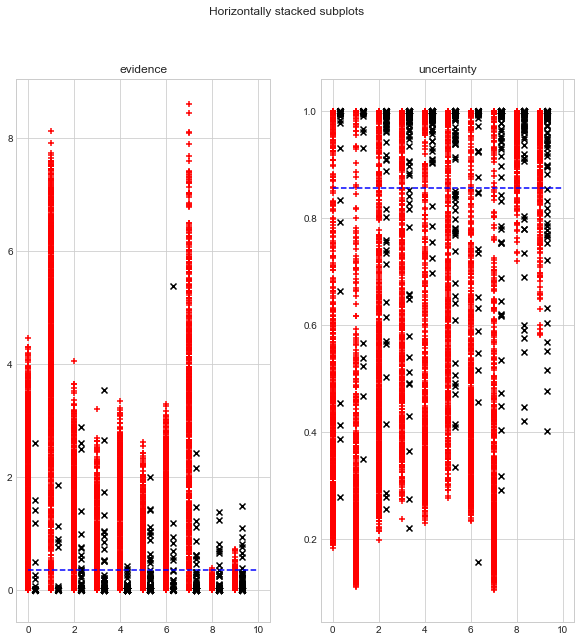

In [225]:
fig, axs = plt.subplots(1, 2)
    
correct_rows = Predictions.loc[Predictions['Acc'] == True]
incorrect_rows = Predictions.loc[Predictions['Acc'] == False]

fig.suptitle('Horizontally stacked subplots')
axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
axs[0].plot(np.repeat(E_threshold,11),'b--')
axs[0].set_title("evidence")

axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
axs[1].plot(np.repeat(U_threshold,11),'b--')

axs[1].set_title("uncertainty")

fig.set_size_inches(10, 10)
plt.show()

In [59]:
threshold = 0
Predictions['uncertainty'] = 10 / (10+Predictions['evidence'])
correct_rows = Predictions.loc[(Predictions['Acc'] == True) & (Predictions['evidence'] >threshold)]
incorrect_rows = Predictions.loc[(Predictions['Acc'] == False) & (Predictions['evidence'] > threshold)]
# incorrect_rows = Predictions.loc[(Predictions['evidence'] > 40)]
print(correct_rows.count())

print(incorrect_rows.count())
print(incorrect_rows.head())
# print(incorrect_rows.sort_values("evidence"))

uncertainty_correct_rows = Predictions.loc[(Predictions['Acc'] == True) & (Predictions['evidence'] >threshold)]
uncertainty_incorrect_rows = Predictions.loc[(Predictions['Acc'] == False) & (Predictions['evidence'] > threshold)]


class          977
evidence       977
Acc            977
uncertainty    977
dtype: int64
class          22
evidence       22
Acc            22
uncertainty    22
dtype: int64
     class   evidence  Acc  uncertainty
114      4  58.336926  0.0     0.146334
148      2  14.518316  0.0     0.407858
216      6  97.689018  0.0     0.092860
246      4  26.732870  0.0     0.272236
320      2  60.387310  0.0     0.142071


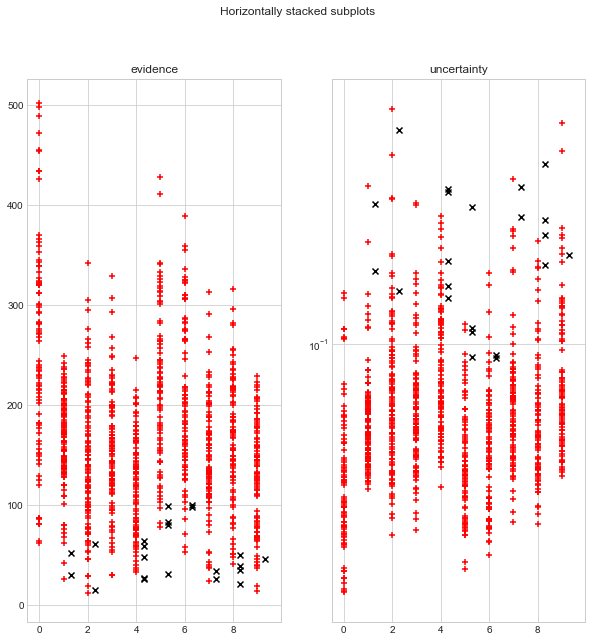

In [60]:
fig, axs = plt.subplots(1, 2)
plt.yscale('log')
fig.suptitle('Horizontally stacked subplots')
axs[0].scatter(correct_rows['class'],correct_rows['evidence'],c ='r',marker='+')
axs[0].scatter(incorrect_rows['class']+.3,incorrect_rows['evidence'],c ='k',marker='x')
axs[0].set_title("evidence")

axs[1].scatter(correct_rows['class'],correct_rows['uncertainty'],c ='r',marker='+')
axs[1].scatter(incorrect_rows['class']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
axs[1].set_title("uncertainty")
fig.set_size_inches(10, 10)


In [441]:
def GetResultsCSV_evidence(model,dataset,suffix="", validation=True):
        num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
        train_ds, test_ds, validation_ds = (dataset)
        predictions = []
        labels = []
        #already compiled
        # model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
        iterator = iter(test_ds)
        print(len(test_ds))

#         for j in range(len(test_ds)):
        for j in range(100):
            print("prediction: {} of {}".format(j,len(test_ds)),end='\r')
            item = iterator.get_next()
            prediction = model.predict(item[0])
            # print("predictions {}".format(prediction))
            predictions.append(prediction)
            # print(prediction)
            labels.append(item[1].numpy().tolist())
        print("labels")
        # print(labels)
        for i, val in enumerate(labels):
            # print(i)
            labels[i]= [np.argmax(val)]* num_outputs

        predEvidence_fail =[]
        predEvidence_fail_uncert =[]
        predEvidence_true = []
        predEvidence_true_uncert =[]
        predEvidence_fail_label =[]
        predEvidence_true_label =[]
        predClasses =[]
        predRaw=[]
        print("predictions complete, analyizing") 
        for i,output in enumerate(predictions):
            for k, pred in enumerate(output):

                pred_classes=[]
                pred_evidence = []
                pred_Raw=[]
                print("image: {} of {}".format(i,len(predictions)),end='\r')
                # print("output: ",i)
                if(type(pred[0])==list):
                    for l, branch in enumerate(pred):
                        pred_Raw.append(branch)
                        Pclass = np.argmax(branch)
                        pred_classes.append(Pclass) 
                        evidence = exp_evidence(branch).numpy()
                        total_evidence = evidence
                        match = tf.reshape(tf.cast(tf.equal(Pclass, labels[i]), tf.float32),(-1,1))                    
                        if l !=0:
                            if match.numpy()[0]==0:
                                # print("match", match.numpy(),total_evidence.numpy())
                                
                                ev_fail = evidence + 1
                                predEvidence_fail.append(ev_fail.numpy())
                                predEvidence_fail_uncert.append(K / ev_fail.numpy())
                                predEvidence_fail_label.append(labels[i][0])
                            else:
                                # print(labels[i])

                                ev_succ = evidence
                                predEvidence_true.append(ev_succ)
                                predEvidence_true_uncert.append(K /ev_succ.numpy())
                                predEvidence_true_label.append(labels[i][0])
                                                
                            # print(total_evidence.numpy())
                        pred_evidence.append(total_evidence)
                else:
                    # print("predictions", pred)

                    pred_Raw.append(pred)
                    Pclass = np.argmax(pred)
                    pred_classes.append(Pclass) 
                    evidence = tf.reduce_sum(exp_evidence(pred)).numpy()
                    # print(evidence)
                    total_evidence = evidence
                    match = tf.reshape(tf.cast(tf.equal(Pclass, labels[i]), tf.float32),(-1,1))  
                    # print(match)                  
                    if match.numpy()[0]==0:
                        # print("fail")
                        # print("match", match.numpy(),total_evidence.numpy())
                        
                        ev_fail = (evidence)*(1-0) / (1+1e-20) 
                        predEvidence_fail.append(ev_fail)
                        predEvidence_fail_uncert.append(K/ (K + ev_fail))
                        predEvidence_fail_label.append(labels[i][0])
                    else:
                        # print(labels[i])

                        ev_succ = (evidence)*1 / (1+1e-20)
                        predEvidence_true.append(ev_succ)
                        predEvidence_true_uncert.append(K/ (K + ev_succ))
                        predEvidence_true_label.append(labels[i][0])
                                            
                        # print(total_evidence.numpy())
                    pred_evidence.append(total_evidence)
        
              
        labelClasses = [0,1,2,3,4,5,6,7,8,9]
        # predClasses = pd.DataFrame(predClasses)
        labels = pd.DataFrame(labels)
        predEvidence_fail = pd.DataFrame([predEvidence_fail])
        predEvidence_true = pd.DataFrame([predEvidence_true])
        
        import matplotlib.pyplot as plt

        # predEvidence_true = [K / K+ x for x in predEvidence_true]
        # predEvidence_fail = [K / K+ x for x in predEvidence_fail]

        # print(len(predEvidence_true))
        # print(len(predEvidence_true_label))
        print("mean Success: ",tf.reduce_mean(predEvidence_true))
        # print(predEvidence_true)
        print("mean Fail: ",tf.reduce_mean(predEvidence_fail))

        predEvidence_fail_label = [x+.2 for x in predEvidence_fail_label]
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        axs[0].scatter(predEvidence_true_label,predEvidence_true,c ='r',marker='+')
        axs[0].scatter(predEvidence_fail_label,predEvidence_fail,c ='k',marker='x')
        axs[0].set_title("evidence")

        axs[1].scatter(predEvidence_true_label,predEvidence_true_uncert,c ='r',marker='*')
        axs[1].scatter(predEvidence_fail_label,predEvidence_fail_uncert,c ='k',marker='*')
        axs[1].set_title("uncertainty")

        fig.set_size_inches(10, 10)
        plt.show()
        
        
        
        return
        
        

10000
labelstion: 9999 of 10000
predictions complete, analyizing
mean Success:  tf.Tensor(11.712669773054586, shape=(), dtype=float64)
mean Fail:  tf.Tensor(11.542338025336171, shape=(), dtype=float64)


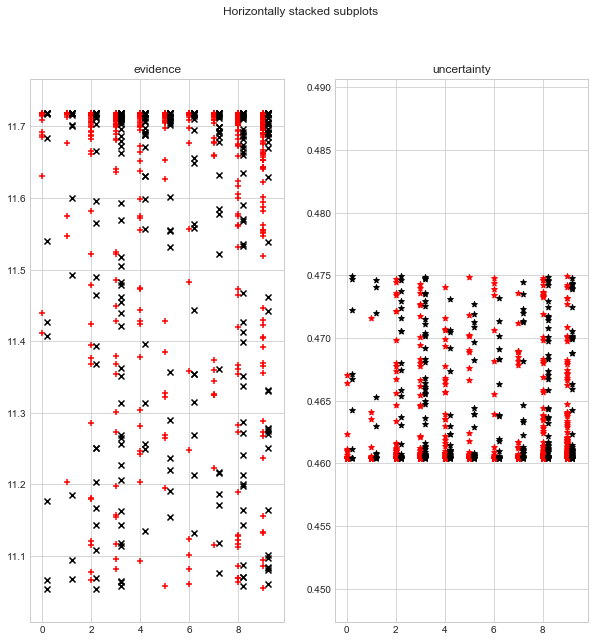

In [272]:
results = GetResultsCSV_evidence(model,(train_ds, test_ds, validation_ds),suffix="new_model", validation=True)

10000
labelstion: 99 of 10000
predictions complete, analyizing
mean Success:  tf.Tensor(11.716626070966624, shape=(), dtype=float64)
mean Fail:  tf.Tensor(11.55577278137207, shape=(), dtype=float64)


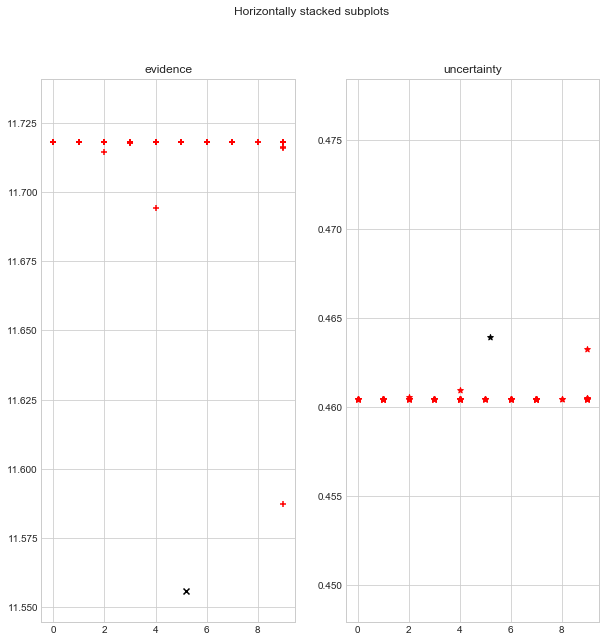

In [274]:
results = GetResultsCSV_evidence(model,(train_ds, test_ds, validation_ds),suffix="new_model", validation=True)

In [425]:
results.head()

AttributeError: 'NoneType' object has no attribute 'head'